In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
df = pd.read_csv("NewApplications_Lender3_Round1.csv")

id = df["id"]

In [3]:
id

0             1
1             2
2             3
3             4
4             5
          ...  
99995     99996
99996     99997
99997     99998
99998     99999
99999    100000
Name: id, Length: 100000, dtype: int64

In [4]:
df.drop(["id"], axis=1, inplace=True)

In [5]:
df

,sex,employment,married,income,digital3
0,M,employed,0,29758,0.000000
1,F,retired,1,6140,0.000000
2,F,employed,1,27186,0.000000
3,M,employed,1,8429,0.734011
4,M,retired,1,2820,0.000000
...,...,...,...,...,...
99995,M,retired,1,9027,0.213033
99996,M,student,0,6229,0.698103
99997,M,employed,1,6471,0.751646
99998,M,unemployed,0,32654,0.000000


In [6]:
df["log_income"] = np.log1p(df["income"])
df["income"] = StandardScaler().fit_transform(df["income"].values.reshape(-1, 1))
df = pd.get_dummies(df, columns=["employment", "sex"], drop_first=True)


In [7]:
# Load PCA model
pca = joblib.load("pca_model.pkl")

# Apply PCA
X_pca = pca.transform(df)

# Create a DataFrame with the PCA features
X_pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])

X = pd.concat([df, X_pca_df], axis=1)

X.head()

,married,income,digital3,log_income,employment_retired,employment_student,employment_unemployed,sex_M,PCA1,PCA2
0,0,0.222847,0.000000,10.300887,False,False,False,True,2.443820,0.019120
1,1,-0.254171,0.000000,8.722743,True,False,False,False,0.866873,-0.389824
2,1,0.170900,0.000000,10.210494,False,False,False,False,2.373644,-0.066049
3,1,-0.207940,0.734011,9.039552,False,False,False,True,1.175623,-0.310462
4,1,-0.321226,0.000000,7.944847,True,False,False,True,0.096232,-0.370588


In [10]:
# import the calibrated pipeline
pipeline = joblib.load("calibrated_mlp_model_pipeline.pkl")

In [11]:
# Predict the probability of default
y_pred = pipeline.predict_proba(X)[:, 1]


In [12]:
# Create a DataFrame with the predictions
predictions = pd.DataFrame(y_pred, columns=["estimated_probability_of_default"])
predictions = pd.concat([df, predictions], axis=1)

In [13]:
predictions

,married,income,digital3,log_income,employment_retired,employment_student,employment_unemployed,sex_M,estimated_probability_of_default
0,0,0.222847,0.000000,10.300887,False,False,False,True,0.021763
1,1,-0.254171,0.000000,8.722743,True,False,False,False,0.150297
2,1,0.170900,0.000000,10.210494,False,False,False,False,0.036447
3,1,-0.207940,0.734011,9.039552,False,False,False,True,0.073309
4,1,-0.321226,0.000000,7.944847,True,False,False,True,0.247205
...,...,...,...,...,...,...,...,...,...
99995,1,-0.195862,0.213033,9.108086,True,False,False,True,0.067391
99996,0,-0.252374,0.698103,8.737132,False,True,False,True,0.082756
99997,1,-0.247486,0.751646,8.775240,False,False,False,True,0.104658
99998,0,0.281339,0.000000,10.393753,False,False,True,True,0.013887


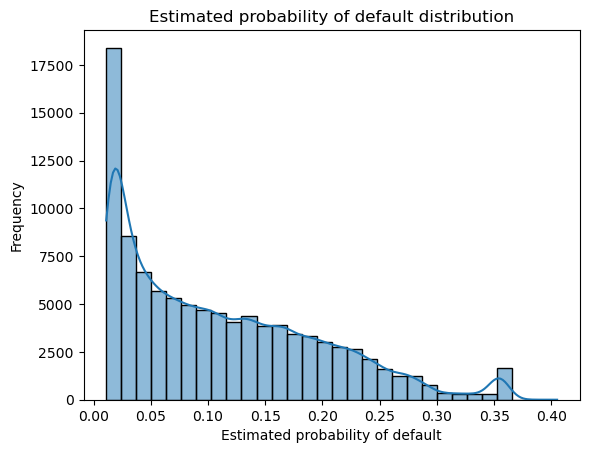

In [14]:
# Plot the distribution of the estimated probability of default
sns.histplot(predictions["estimated_probability_of_default"], bins=30, kde=True)
plt.xlabel("Estimated probability of default")
plt.ylabel("Frequency")
plt.title("Estimated probability of default distribution")
plt.show()


This distribution pattern is very similar to what was seen in the test set, which indicates that the model generalizes well and is consistent in predicting probabilities for new applicants.

Interest Rate Calculation Based on Predicted Probabilities:

Use the break-even interest rate formula for each applicant:
$$
r_i = \frac{PD_i}{1 - PD_i}
$$

where $PD_i$ is the predicted probability of default for applicant $i$.

We can then adjust the interest rate to include a risk premium based on business strategy.

Risk Segmentation:
Three categories of borrowers:
- **Low risk**: Borrowers with $< 0.10$ : 2%
- **Moderate risk**: Borrowers with $PD$ between $0.10$ and $0.20$ : 3%
- **High risk**: Borrowers with $PD$ between $0.20$ and $0.25$: 4%
- **Very High risk**: Borrowers with $PD > 0.25$ : No offer

In [15]:
def calculate_breakeven_rate(pd):
    return pd / (1 - pd)


In [16]:
# Calculate the breakeven rate
predictions["breakeven_rate"] = calculate_breakeven_rate(
    predictions["estimated_probability_of_default"]
)


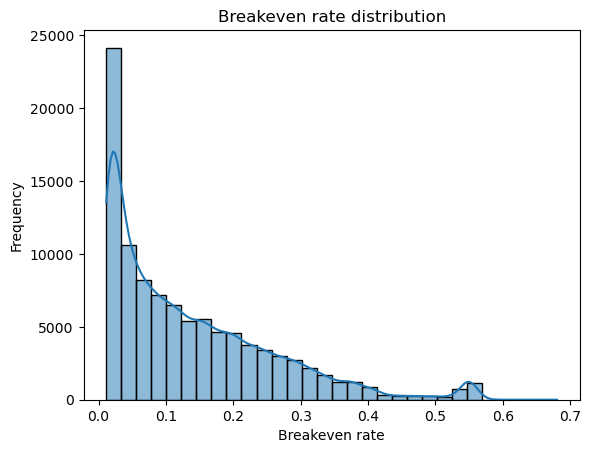

In [17]:
# Plot break-even rate distribution
sns.histplot(predictions["breakeven_rate"], bins=30, kde=True)
plt.xlabel("Breakeven rate")
plt.ylabel("Frequency")
plt.title("Breakeven rate distribution")
plt.show()


In [19]:
# Calculate interest rate
def calculate_interest_rate(pd):
    if pd < 0.1:
        return pd + 0.02
    elif pd < 0.2:
        return pd + 0.03
    elif pd < 0.25:
        return pd + 0.04
    else:
        return None

In [20]:
predictions["interest_rate"] = predictions["estimated_probability_of_default"].apply(
    calculate_interest_rate
)

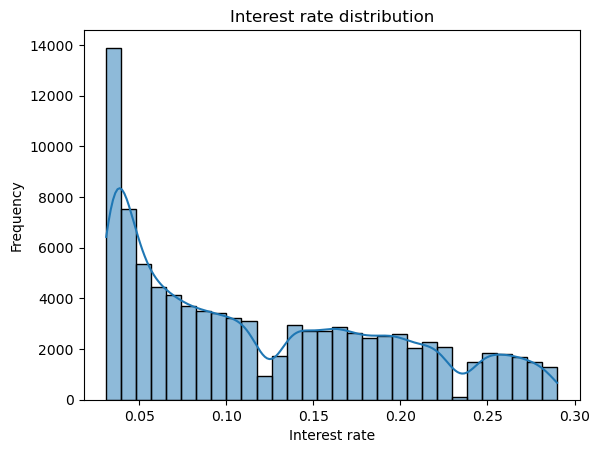

In [21]:
# Plot interest rate distribution
sns.histplot(predictions["interest_rate"], bins=30, kde=True)
plt.xlabel("Interest rate")
plt.ylabel("Frequency")
plt.title("Interest rate distribution")
plt.show()


In [22]:
# Calculate the expected profit
def calculate_expected_profit(pd, loan_amount, interest_rate):
    if interest_rate is None:
        return None
    else:
        return loan_amount * (interest_rate - pd)

In [23]:
loan_amount = 10000
predictions["expected_profit"] = predictions.apply(
    lambda x: calculate_expected_profit(
        x["estimated_probability_of_default"], loan_amount, x["interest_rate"]
    ),
    axis=1,
)

# Total expected profit
total_expected_profit = predictions["expected_profit"].sum()
print(f"Total expected profit with no competition: {total_expected_profit:.2f}")

# Calculate the expected profit with equal competition
print(f"Total expected profit with equal competition: {total_expected_profit / 3:.2f}")


Total expected profit with no competition: 23420800.00
Total expected profit with equal competition: 7806933.33


In [24]:
# Create final submissions dataframe
submissions = pd.DataFrame({"id": id, "rate": predictions["interest_rate"]})

In [25]:
submissions.to_csv("submissions.csv", index=False)

In [27]:
submissions["rate"] = submissions["rate"].apply(lambda x: round(x, 4))


In [29]:
submissions.to_csv("submissions_rounded.csv", index=False)